In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring.pkl` file or `features_ring` folder, updating the path accordingly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

In [2]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label `Unclassified` to None values in the column `Interaction`

In [3]:
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


Mapping the string labels to numericals

In [4]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

y = df['Interaction'].replace(contact_dict)

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_16344/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


Apply a mask in order to get only the needed features to put in the dataset

In [ ]:
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

Encoding the categorical features and dropping the `3di_letter` since it represent the same thing of `3di_state`

In [ ]:
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

Counting the missing values in order to make a choice:
- drop the rows with missing values
- fill the rows with missing values by putting the mean value of the column

In [6]:
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


Dropping the rows with missing values

In [ ]:
# Count initial shape of X and y
print(f"Initial shape - X: {X.shape}, y: {y.shape}")

# Identify rows with any missing values
rows_with_missing = X.isna().any(axis=1)
print(f"Found {rows_with_missing.sum()} rows with missing values")

# Create a boolean mask for valid rows
valid_indices = ~rows_with_missing

# Apply the same mask to both X and y to keep them aligned
X = X[valid_indices]
y = y[valid_indices]  

print(f"New shape after removing rows - X: {X.shape}, y: {y.shape}")

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values after deletion: {total_missing}\n")

Filling the rows with missing values with the mean of the values of that column

In [7]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


This cell it is necessary for eventually engine some features and mandatory for `feature_importance` method

In [8]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


For each `features` are computed the following math operations:
*   Sum
*   Product
*   Absolute difference
*   Average

In [ ]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names

Append the new features created

In [ ]:
for feature in features:
  feature_names.extend(fe(feature))

## Splitting dataset

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE 

Computing the inital class distribution

In [ ]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

Applying a sampling strategy in order to oversampling and computing new distribution

In [ ]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")

## XGBoost

### Helper functions

This method compute and plot the feature importance that contributes to the prediction

In [ ]:
def feature_importance(model, interaction_type, feature_names):
  # Get feature importances from the model

  importance = model.get_score(importance_type='weight')  

  # Mapping feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sorting the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Plotting the feature importance
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis() 
  plt.show()

Method that evaluates the models and compute the features importance

In [ ]:
import time

def evaluate_model(model, X_test, y_test, class_num, feature_names):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for the current class
    y_test_binary = (y_test == class_num).astype(int)
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")

    # Compute feature importance
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

Here are listed the hypeparameters configurations class-specific

In [ ]:
class_params = {
       0: {  # HBOND
            'max_depth': 10,             
            'learning_rate': 0.2,         
            'min_child_weight': 4,       
            'subsample': 0.8,              
            'colsample_bytree': 0.8,       
            'gamma': 0.1,                  
            'reg_alpha': 0.1,              
            'reg_lambda': 1.0,             
        },
        1: {  # VDW 
            'max_depth': 8,
            'learning_rate': 0.1,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
        },
        2: {  # PIPISTACK
            'max_depth': 8,             
            'learning_rate': 0.02,        
            'min_child_weight': 3,      
            'subsample': 0.85,            
            'colsample_bytree': 0.7,      
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        3: {  # IONIC 
            'max_depth': 8,
            'learning_rate': 0.02,
            'min_child_weight': 3,
            'subsample': 0.85,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        4: {  # PICATION
            'max_depth': 6,              
            'learning_rate': 0.01,
            'min_child_weight': 7,       
            'subsample': 0.9,
            'colsample_bytree': 0.7,      
            'gamma': 0.3,
            'reg_alpha': 0.5,             
            'reg_lambda': 2.0,             
        },
        5: {  # SSBOND 
            'max_depth': 6,
            'learning_rate': 0.01,
            'min_child_weight': 7,
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        6: {  # PIHBOND 
            'max_depth': 6,
            'learning_rate': 0.01,
            'min_child_weight': 3,
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        7: {  # Unclassified
            'max_depth': 10,            
            'learning_rate': 0.2,        
            'min_child_weight': 1,      
            'subsample': 0.8,            
            'colsample_bytree': 0.7,     
            'gamma': 0.1,                
            'reg_alpha': 0.1,            
            'reg_lambda': 1.0,           
        }
    }

### Train loop

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.63490	validation-error:0.43058	validation-aucpr:0.47274
[10]	validation-auc:0.67712	validation-error:0.39879	validation-aucpr:0.51334
[20]	validation-auc:0.69049	validation-error:0.38799	validation-aucpr:0.52830
[30]	validation-auc:0.69908	validation-error:0.37862	validation-aucpr:0.53732
[40]	validation-auc:0.70291	validation-error:0.37441	validation-aucpr:0.54144
[50]	validation-auc:0.70742	validation-error:0.36944	validation-aucpr:0.54636
[60]	validation-auc:0.70964	validation-error:0.36711	validation-aucpr:0.54843
[70]	validation-auc:0.71156	validation-error:0.36447	validation-aucpr:0.55014
[80]	validation-auc:0.71290	validation-error:0.36227	validation-aucpr:0.55130
[90]	validation-auc:0.71369	validation-error:0.36127	validation-aucpr:0.55143
[100]	validation-auc:0.71385	validation-error:0.36049	validation-aucpr:0.55131
[110]	validation-auc:0.71428	validation-error:0.35962	validation-aucpr:0.55132
[120]	validation-auc:0.71457	validation-error:0.35880	validatio

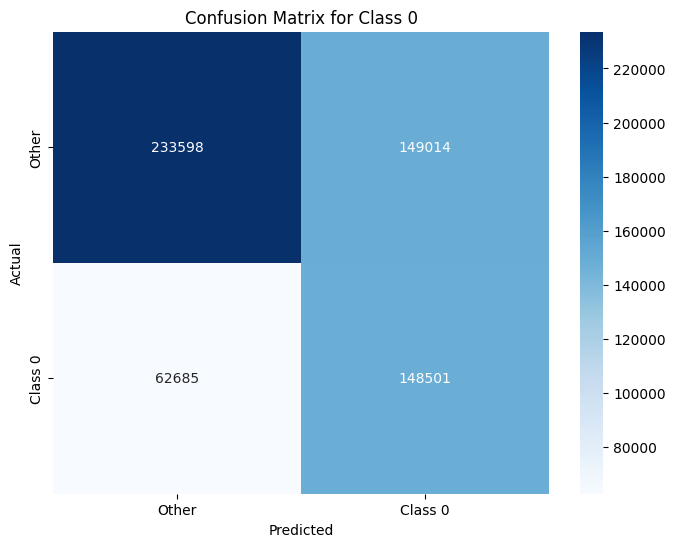


===== Feature Importance for Class 0 =====


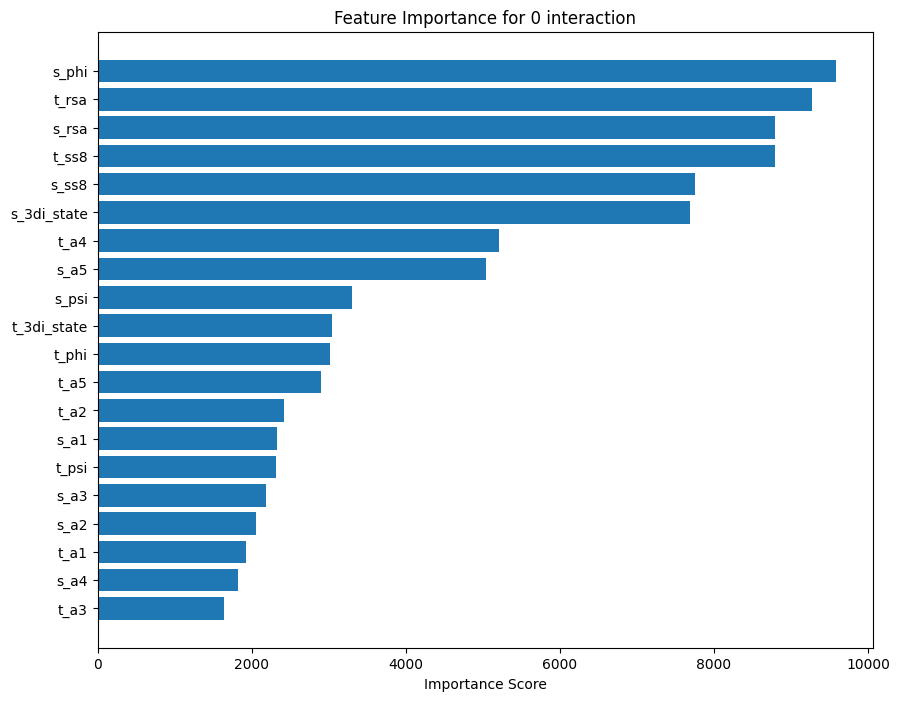

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.54142	validation-error:0.48016	validation-aucpr:0.27554
[10]	validation-auc:0.55355	validation-error:0.49583	validation-aucpr:0.28274
[20]	validation-auc:0.55547	validation-error:0.49175	validation-aucpr:0.28439
[30]	validation-auc:0.55702	validation-error:0.48820	validation-aucpr:0.28561
[40]	validation-auc:0.55817	validation-error:0.48364	validation-aucpr:0.28629
[50]	validation-auc:0.55875	validation-error:0.48256	validation-aucpr:0.28659
[60]	validation-auc:0.55916	validation-error:0.48119	validation-aucpr:0.28691
[70]	validation-auc:0.55952	validation-error:0.47916	validation-aucpr:0.28719
[80]	validation-auc:0.55981	validation-error:0.47707	validation-aucpr:0.28725
[90]	validation-auc:0.56005	validation-error:0.47581	validation-aucpr:0.28736
[100]	validation-auc:0.56003	validation-error:0.47399	validation-aucpr:0.28727
[110]	validation-auc:0.55987	validation-error:0.47328	validation-aucpr:0.28714
[120]	validation-auc:0.55974	validation-error:0.47236	validatio

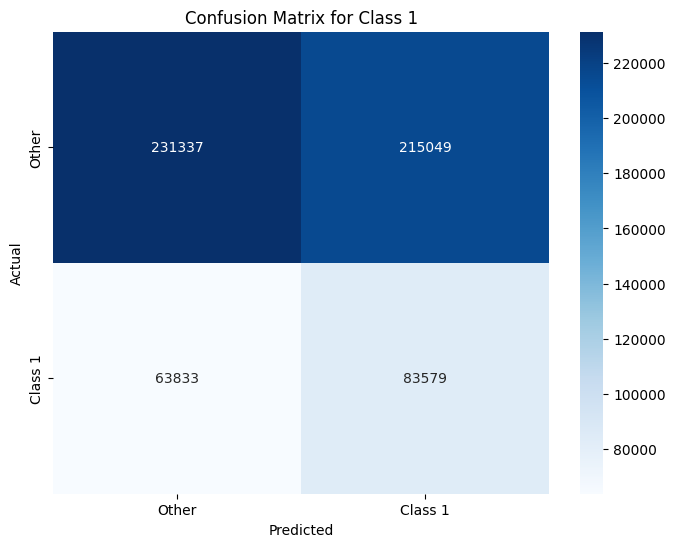


===== Feature Importance for Class 1 =====


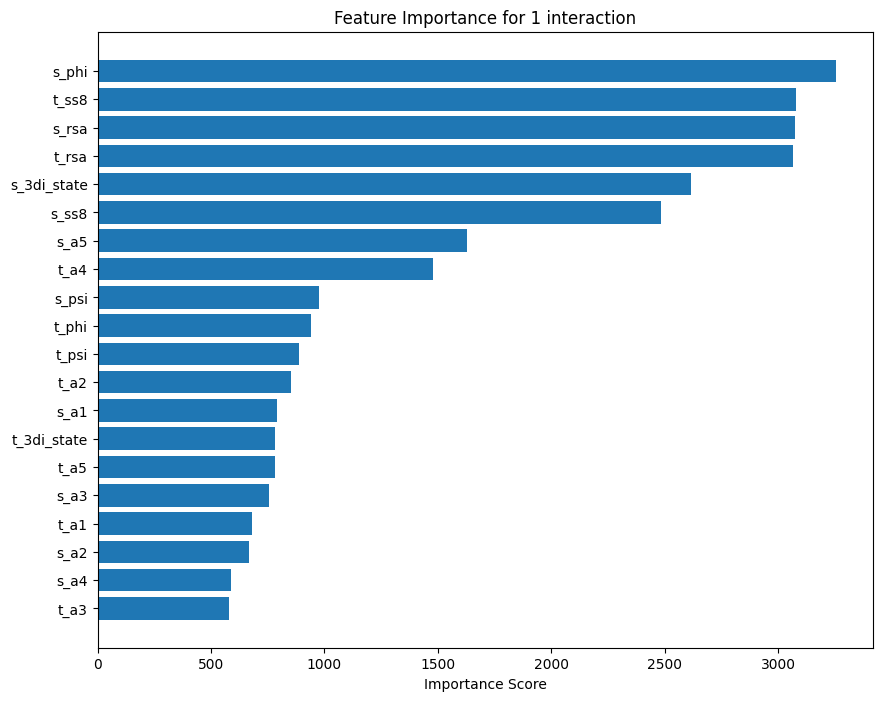

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:08:39] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.95251	validation-error:0.09359	validation-aucpr:0.12105
[10]	validation-auc:0.98937	validation-error:0.02840	validation-aucpr:0.38247
[20]	validation-auc:0.98937	validation-error:0.02078	validation-aucpr:0.38247
[30]	validation-auc:0.98936	validation-error:0.02078	validation-aucpr:0.38241
[40]	validation-auc:0.98936	validation-error:0.02078	validation-aucpr:0.38241
[50]	validation-auc:0.98941	validation-error:0.02078	validation-aucpr:0.38365
[60]	validation-auc:0.98943	validation-error:0.02078	validation-aucpr:0.38389
[70]	validation-auc:0.98949	validation-error:0.02078	validation-aucpr:0.38533
[80]	validation-auc:0.98996	validation-error:0.02078	validation-aucpr:0.40027
[90]	validation-auc:0.98970	validation-error:0.02078	validation-aucpr:0.38912
[100]	validation-auc:0.99029	validation-error:0.02078	validation-aucpr:0.41569
[110]	validation-auc:0.99042	validation-error:0.02078	validation-aucpr:0.42844
[120]	validation-auc:0.99037	validation-error:0.02078	validatio

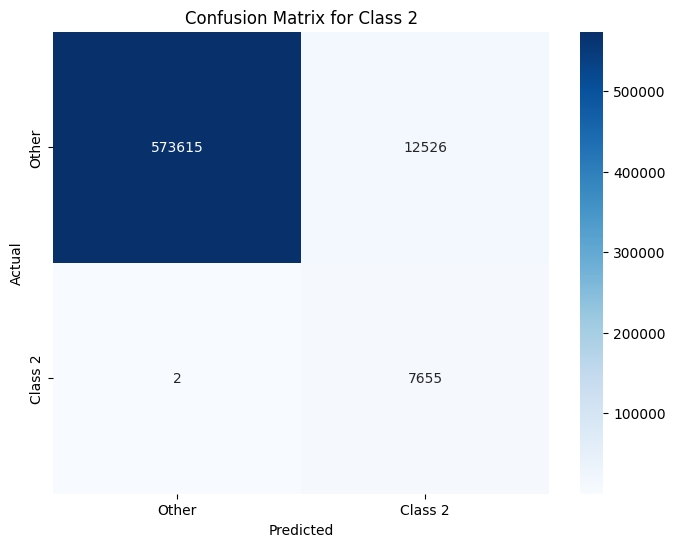


===== Feature Importance for Class 2 =====


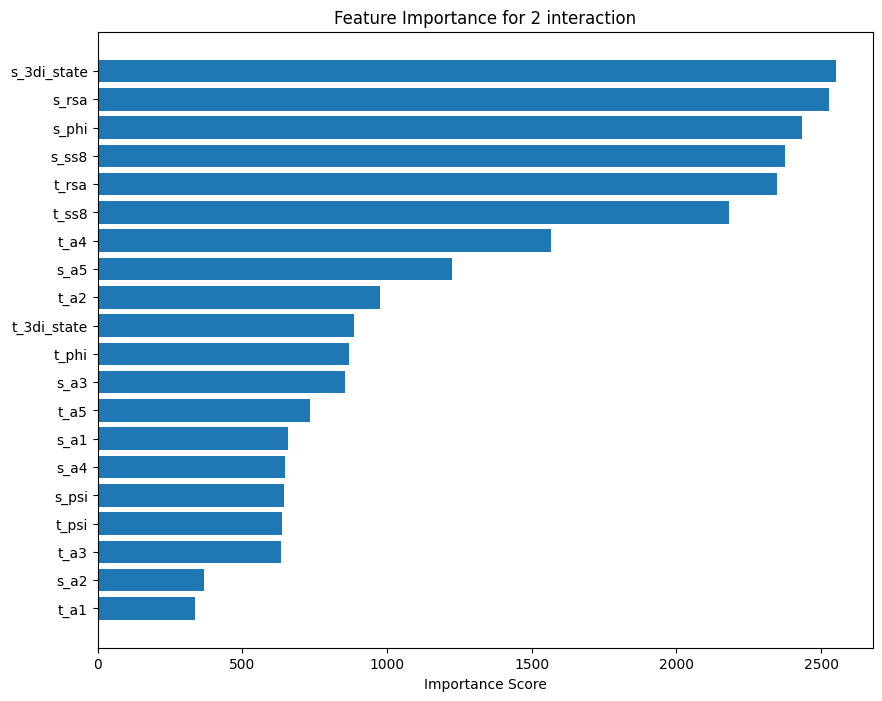

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:09:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.93336	validation-error:0.13152	validation-aucpr:0.08309
[10]	validation-auc:0.96242	validation-error:0.08425	validation-aucpr:0.13900
[20]	validation-auc:0.96414	validation-error:0.08424	validation-aucpr:0.14510
[30]	validation-auc:0.97143	validation-error:0.08418	validation-aucpr:0.17829
[40]	validation-auc:0.97277	validation-error:0.08413	validation-aucpr:0.18774
[50]	validation-auc:0.97534	validation-error:0.08404	validation-aucpr:0.21450
[60]	validation-auc:0.97631	validation-error:0.08398	validation-aucpr:0.22714
[70]	validation-auc:0.97663	validation-error:0.08390	validation-aucpr:0.23264
[80]	validation-auc:0.97694	validation-error:0.08374	validation-aucpr:0.23589
[90]	validation-auc:0.97697	validation-error:0.08356	validation-aucpr:0.23681
[100]	validation-auc:0.97697	validation-error:0.08344	validation-aucpr:0.23658
[110]	validation-auc:0.97700	validation-error:0.08324	validation-aucpr:0.23732
[120]	validation-auc:0.97702	validation-error:0.08309	validatio

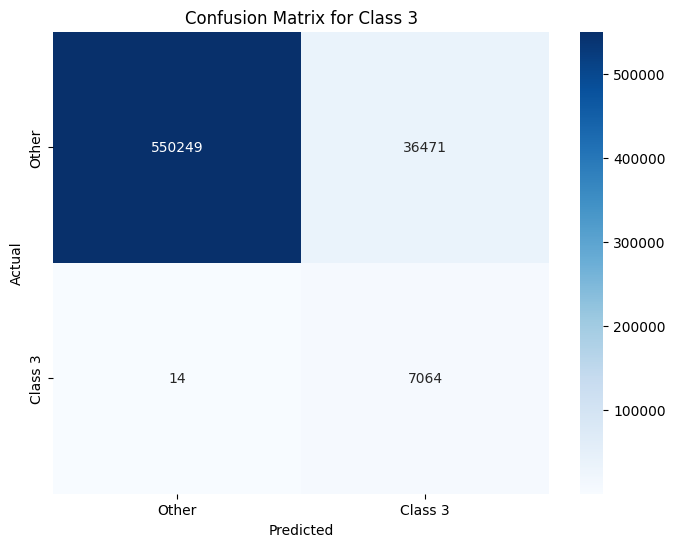


===== Feature Importance for Class 3 =====


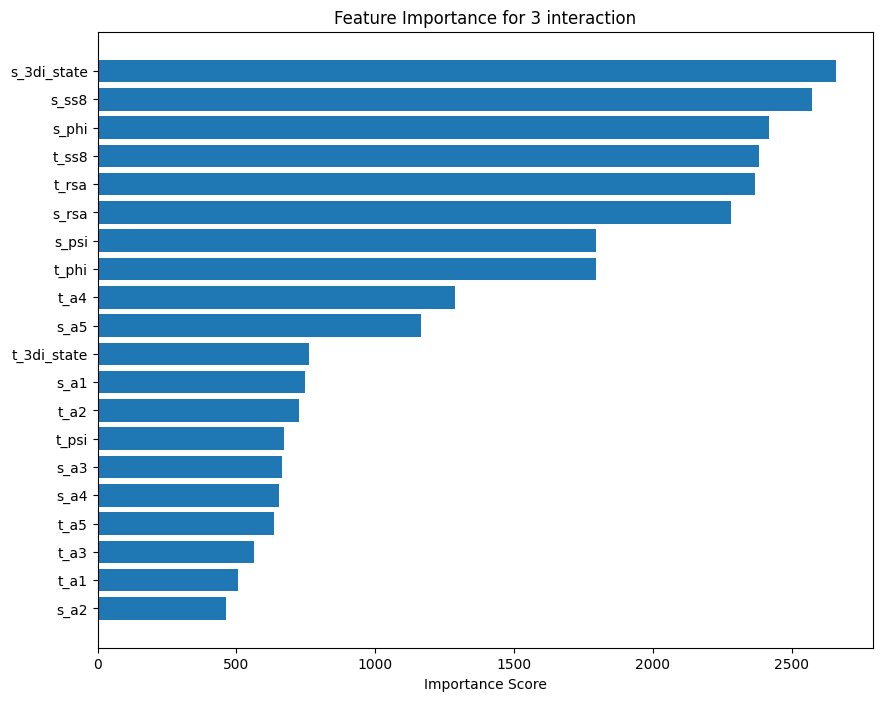

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:10:40] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.91040	validation-error:0.17796	validation-aucpr:0.01652
[10]	validation-auc:0.97068	validation-error:0.11430	validation-aucpr:0.04934
[20]	validation-auc:0.97069	validation-error:0.09931	validation-aucpr:0.04939
[30]	validation-auc:0.98030	validation-error:0.09931	validation-aucpr:0.07330
[40]	validation-auc:0.98052	validation-error:0.09931	validation-aucpr:0.07330
[50]	validation-auc:0.98076	validation-error:0.09931	validation-aucpr:0.07402
[60]	validation-auc:0.98679	validation-error:0.09931	validation-aucpr:0.10590
[70]	validation-auc:0.98784	validation-error:0.09931	validation-aucpr:0.11741
[80]	validation-auc:0.98804	validation-error:0.09931	validation-aucpr:0.12680
[90]	validation-auc:0.98817	validation-error:0.09931	validation-aucpr:0.12841
[100]	validation-auc:0.98787	validation-error:0.09931	validation-aucpr:0.12591
[110]	validation-auc:0.98790	validation-error:0.09931	validation-aucpr:0.12618
[120]	validation-auc:0.98818	validation-error:0.09931	validatio

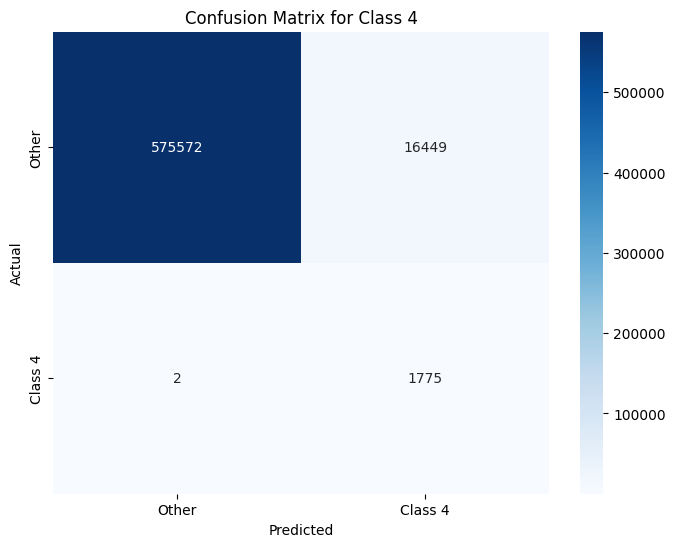


===== Feature Importance for Class 4 =====


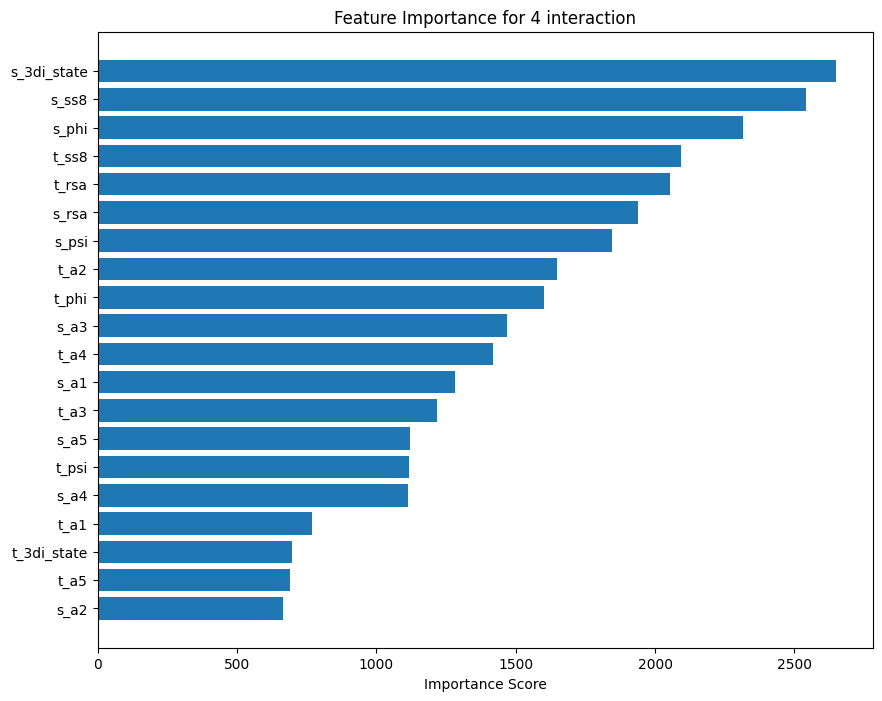

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:13:11] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[10]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[20]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[30]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[40]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[50]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9988
Balanced Accuracy      0.9994
AUC-ROC                0.9994
Matthews Correlation   0.6098
Average Precision      0.3723
Inference Time (ms)   39.0129


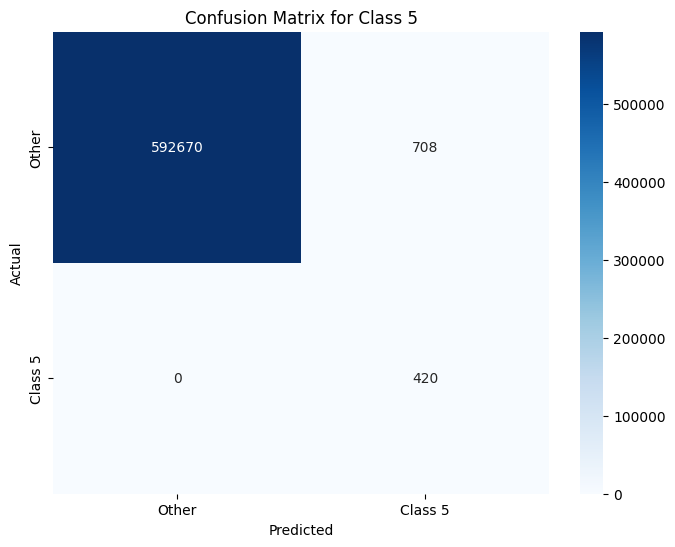


===== Feature Importance for Class 5 =====


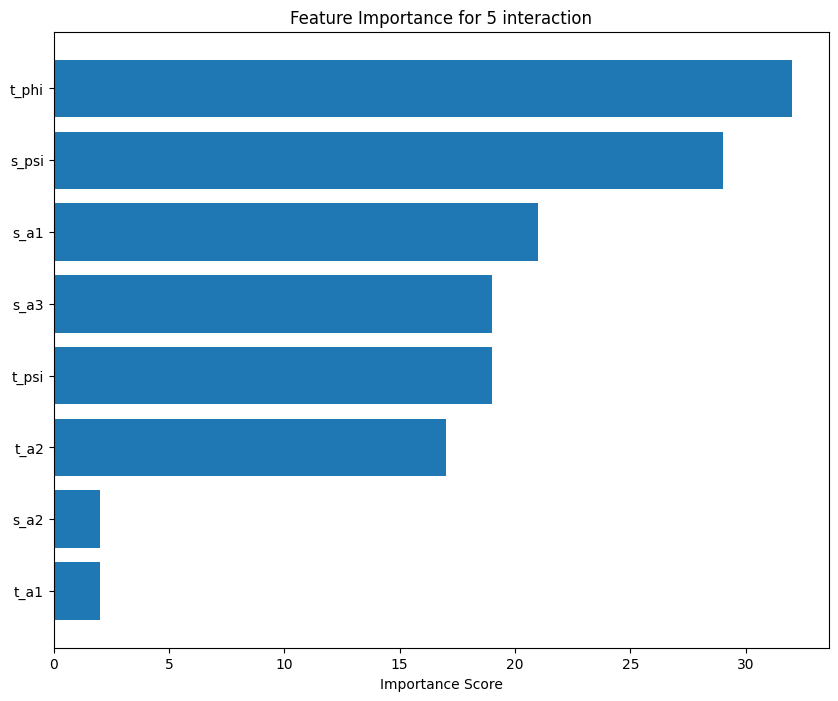

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:13:15] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.85321	validation-error:0.29758	validation-aucpr:0.00295
[10]	validation-auc:0.93645	validation-error:0.15460	validation-aucpr:0.00635
[20]	validation-auc:0.93955	validation-error:0.15087	validation-aucpr:0.00726
[30]	validation-auc:0.94327	validation-error:0.15357	validation-aucpr:0.00837
[40]	validation-auc:0.94174	validation-error:0.15199	validation-aucpr:0.00827
[50]	validation-auc:0.94388	validation-error:0.15376	validation-aucpr:0.00910
[60]	validation-auc:0.94471	validation-error:0.15430	validation-aucpr:0.00923
[70]	validation-auc:0.94529	validation-error:0.15206	validation-aucpr:0.00971
[80]	validation-auc:0.94598	validation-error:0.15030	validation-aucpr:0.00999
[90]	validation-auc:0.94688	validation-error:0.14926	validation-aucpr:0.01037
[100]	validation-auc:0.94715	validation-error:0.14701	validation-aucpr:0.01114
[110]	validation-auc:0.94759	validation-error:0.14429	validation-aucpr:0.01128
[120]	validation-auc:0.94854	validation-error:0.14275	validatio

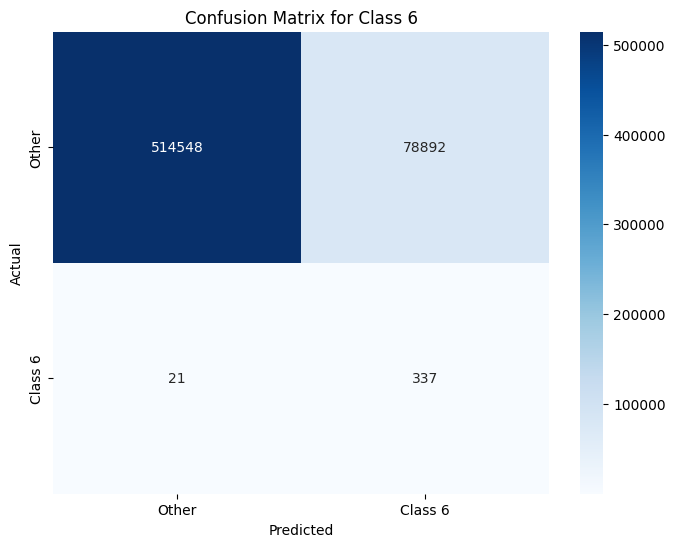


===== Feature Importance for Class 6 =====


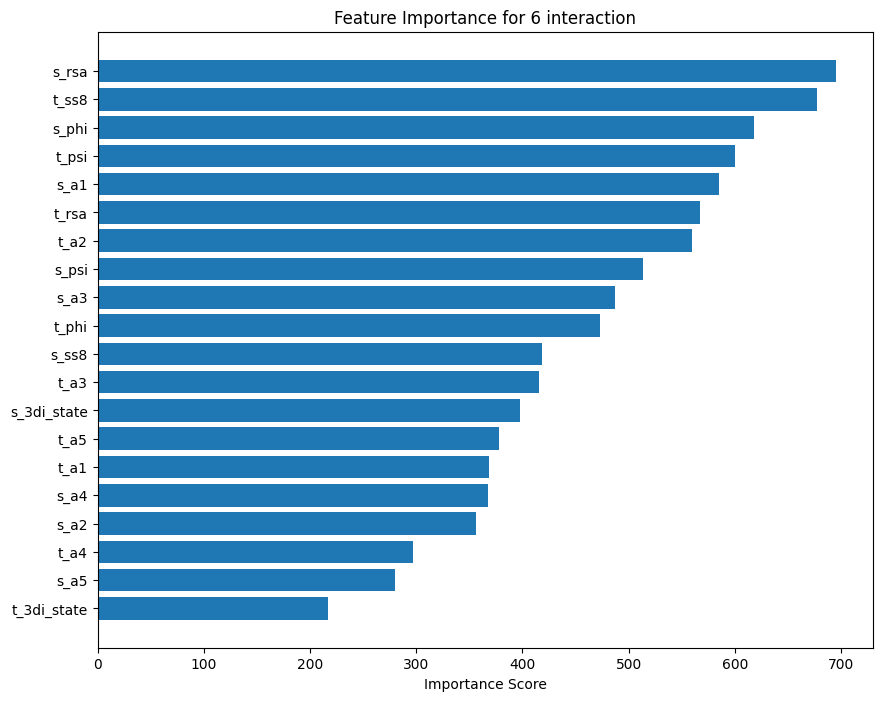

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [11:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.63756	validation-error:0.39753	validation-aucpr:0.50226
[10]	validation-auc:0.69690	validation-error:0.35654	validation-aucpr:0.56387
[20]	validation-auc:0.71148	validation-error:0.34428	validation-aucpr:0.57966
[30]	validation-auc:0.71882	validation-error:0.33861	validation-aucpr:0.58795
[40]	validation-auc:0.72300	validation-error:0.33530	validation-aucpr:0.59265
[50]	validation-auc:0.72718	validation-error:0.33178	validation-aucpr:0.59720
[60]	validation-auc:0.73089	validation-error:0.32908	validation-aucpr:0.60127
[70]	validation-auc:0.73395	validation-error:0.32730	validation-aucpr:0.60442
[80]	validation-auc:0.73632	validation-error:0.32507	validation-aucpr:0.60712
[90]	validation-auc:0.73854	validation-error:0.32327	validation-aucpr:0.60989
[100]	validation-auc:0.74028	validation-error:0.32203	validation-aucpr:0.61181
[110]	validation-auc:0.74224	validation-error:0.32046	validation-aucpr:0.61395
[120]	validation-auc:0.74346	validation-error:0.31948	validatio

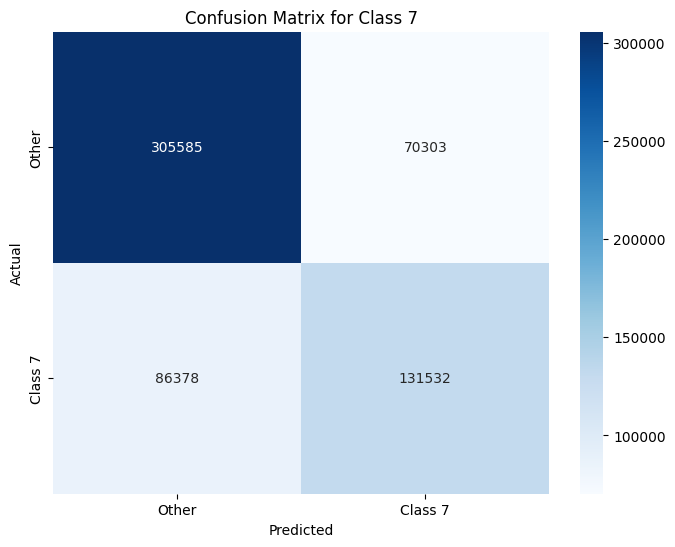


===== Feature Importance for Class 7 =====


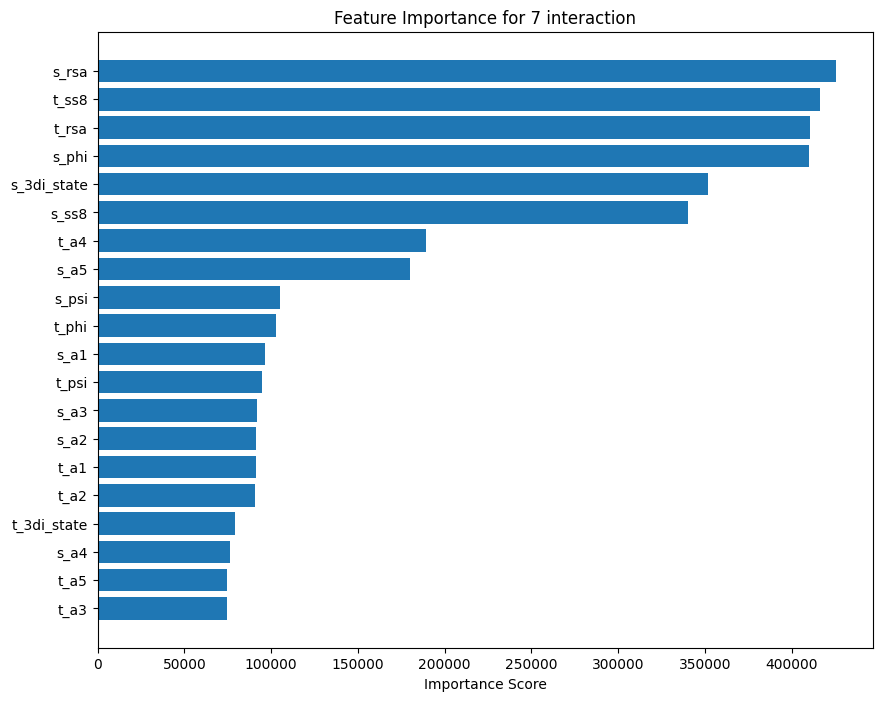

In [ ]:
# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Mapping labels: 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Count num negative/positive examples for this class
    neg_count = np.sum(y_train_binary == 0)
    pos_count = np.sum(y_train_binary == 1)
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    # Get shared base params
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'binary:logistic',
        'eval_metric': ['auc', 'error', 'aucpr'],
        'max_delta_step': 1
    }

    # Add class-specific params
    params.update(class_params[num_class])
    params['scale_pos_weight'] = scale_pos_weight       # Adjust for class imbalance
    
    # Train the model
    model = xgb.train(
        params = params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=10
    )

    # Save model
    os.makedirs(os.path.join(path, 'models/bin_models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/bin_models/xgboost_model_class_{num_class}.json'))

    # Evaluate the model
    evaluate_model(model, X_test, y_test, num_class, feature_names)

## Combines models

Now all the binary classifier will be unified in order to obtain a multiclassifier

In [ ]:
from collections import defaultdict

class UnifiedXGBoostEnsemble:
    """Unified model that combines multiple binary XGBoost models"""

    def __init__(self, models_dir):
        """Load all models from the directory"""
        self.models = []
        self.models_dir = models_dir

        # Load models in order by class number
        for class_num in range(8):  # Assuming 8 classes
            model_path = os.path.join(models_dir, f"xgboost_model_class_{class_num}.json")
            if os.path.exists(model_path):
                model = xgb.Booster()
                model.load_model(model_path)
                self.models.append(model)

        self.n_classes = len(self.models)
        print(f"Successfully loaded {self.n_classes} models from {models_dir}")

    def predict_proba(self, X):
        """Get probability predictions from all models"""
        dtest = xgb.DMatrix(X)
        probas = []

        for model in self.models:
            # Get class probability from each model
            proba = model.predict(dtest)
            probas.append(proba)

        return np.column_stack(probas)

    def predict(self, X):
        """Make final predictions using max probability"""
        probas = self.predict_proba(X)
        probas_normalized = probas / np.sum(probas, axis=1, keepdims=True)

        return np.argmax(probas_normalized, axis=1)

def aggregate_feature_importance(models):
    """Aggregate feature importance scores across multiple models"""
    all_importances = defaultdict(list)
    
    # Collect importances from all models
    for model in models:
        importances = model.get_score(importance_type='weight')
        for feature, score in importances.items():
            all_importances[feature].append(score)
    
    # Compute mean importance for each feature
    mean_importances = {}
    for feature, scores in all_importances.items():
        mean_importances[feature] = sum(scores) / len(scores)
    
    return mean_importances

def evaluate_unified_ensemble(model, X_test, y_test, class_names=None):
    """
    Evaluate the unified ensemble with comprehensive metrics
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.n_classes)]

    print("\n===== Evaluating Unified Ensemble (Max Probability) =====\n")

    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)

    # Calculate overall metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'Matthews Correlation Coefficient'
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            matthews_corrcoef(y_test, y_pred)
        ]
    }

    # Print overall metrics
    metrics_df = pd.DataFrame(metrics)
    print("Overall Metrics:")
    print(metrics_df.set_index('Metric').round(4))

    # Calculate per-class metrics
    roc_aucs = []
    avg_precisions = []

    print("\nPer-Class Metrics:")
    for i in range(model.n_classes):
        # Binary encoding for this class
        y_true_bin = (y_test == i).astype(int)
        y_score = probas[:, i]

        # ROC AUC
        roc_auc = roc_auc_score(y_true_bin, y_score)
        roc_aucs.append(roc_auc)

        # Average Precision
        avg_prec = average_precision_score(y_true_bin, y_score)
        avg_precisions.append(avg_prec)

        print(f"{class_names[i]}: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_prec:.4f}")

    print(f"\nMacro-Average ROC AUC: {np.mean(roc_aucs):.4f}")
    print(f"Macro-Average Precision: {np.mean(avg_precisions):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Unified Ensemble')
    plt.show()

    # Compute feature importance aggregation for the unified ensemble
    feature_importance = aggregate_feature_importance(model.models)
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*feature_importance)     
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('Feature Importance - Unified Ensemble')
    plt.gca().invert_yaxis()  
    plt.show()

    return {
        'accuracy': metrics['Value'][0],
        'balanced_accuracy': metrics['Value'][1],
        'matthews_corr': metrics['Value'][2],
        'roc_auc_per_class': roc_aucs,
        'avg_precision_per_class': avg_precisions,
        'predictions': y_pred,
        'probabilities': probas
    }

Unify the models and evaluation

Successfully loaded 8 models from models/bin_models

===== Evaluating Unified Ensemble (Max Probability) =====

Overall Metrics:
                                   Value
Metric                                  
Accuracy                          0.4727
Balanced Accuracy                 0.6792
Matthews Correlation Coefficient  0.2722

Per-Class Metrics:
HBOND: ROC AUC = 0.7166, Avg Precision = 0.5534
VDW: ROC AUC = 0.5610, Avg Precision = 0.2872
PIPISTACK: ROC AUC = 0.9910, Avg Precision = 0.4440
IONIC: ROC AUC = 0.9783, Avg Precision = 0.2451
PICATION: ROC AUC = 0.9914, Avg Precision = 0.1853
SSBOND: ROC AUC = 0.9994, Avg Precision = 0.3723
PIHBOND: ROC AUC = 0.9589, Avg Precision = 0.0136
Unclassified: ROC AUC = 0.7968, Avg Precision = 0.6744

Macro-Average ROC AUC: 0.8742
Macro-Average Precision: 0.3469


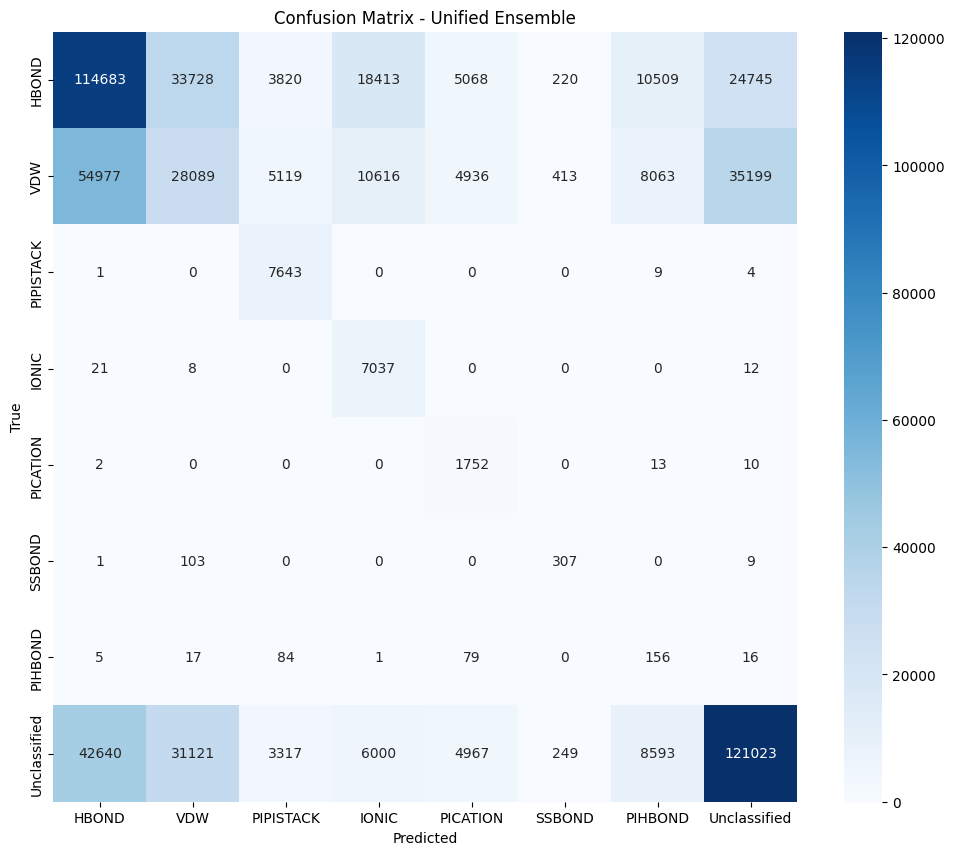

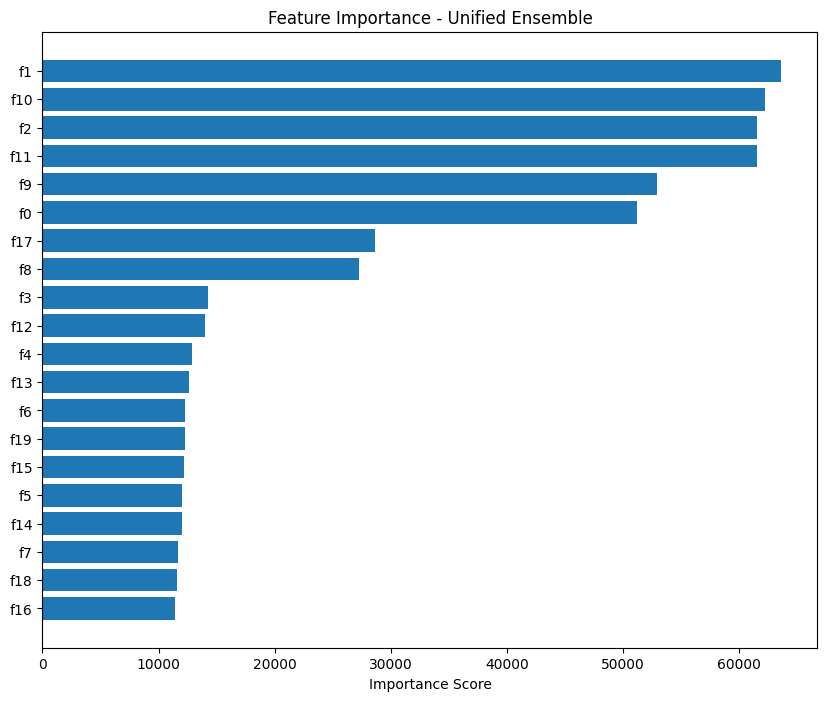

In [ ]:
models_dir = 'models/bin_models'
class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]

unified_model = UnifiedXGBoostEnsemble(models_dir)
results = evaluate_unified_ensemble(unified_model, X_test, y_test, class_names)

## Features selection

For unified model

In [ ]:
from collections import defaultdict

def feature_selection_for_unified_model(model_dir, X_train, y_train, X_test, y_test, feature_names, threshold_method='mean'):
    """
    Perform feature selection for UnifiedXGBoostEnsemble by aggregating feature importance
    from all binary models.
    
    Parameters:
    -----------
    model_dir: str
        Directory containing the binary model files
    X_train, y_train: numpy arrays
        Training data
    X_test, y_test: numpy arrays
        Test data
    feature_names: list
        Names of all features
    threshold_method: str
        Method to determine threshold ('mean', 'median', or float value)
    """
    # Load all binary models
    models = []
    for class_num in range(8):  # Assuming 8 classes
        model_path = os.path.join(model_dir, f"xgboost_model_class_{class_num}.json")
        if os.path.exists(model_path):
            model = xgb.Booster()
            model.load_model(model_path)
            models.append(model)
    
    print(f"Loaded {len(models)} binary models from {model_dir}")
    
    # Aggregate feature importance across all models
    aggregated_importance = defaultdict(float)
    
    for model in models:
        importance = model.get_score(importance_type='weight')
        for feature, score in importance.items():
            feature_idx = int(feature.replace('f', ''))
            aggregated_importance[feature_idx] += score
    
    # Convert to list of (feature_idx, importance) tuples
    importance_list = [(idx, score) for idx, score in aggregated_importance.items()]
    importance_list.sort(key=lambda x: x[1], reverse=True)
    
    # Calculate threshold based on method
    importance_values = np.array([score for _, score in importance_list])
    if threshold_method == 'mean':
        threshold = np.mean(importance_values)
    elif threshold_method == 'median':
        threshold = np.median(importance_values)
    elif isinstance(threshold_method, float):
        threshold = threshold_method
    else:
        threshold = np.mean(importance_values)  # Default to mean
    
    print(f"Feature importance threshold: {threshold:.4f}")
    
    # Select features above threshold
    selected_indices = [idx for idx, score in importance_list if score > threshold]
    
    # If no features selected, use top 10
    if not selected_indices:
        print("No features above threshold, using top 10 instead")
        selected_indices = [idx for idx, _ in importance_list[:10]]
    
    # Ensure indices are within valid range
    selected_indices = [idx for idx in selected_indices if idx < X_train.shape[1]]
    
    print(f"Selected {len(selected_indices)} features out of {X_train.shape[1]}")
    
    # Display selected feature names if available
    if feature_names:
        selected_names = [feature_names[idx] for idx in selected_indices]
        print("Selected features:")
        for idx, name in zip(selected_indices, selected_names):
            print(f"  - {name} (index: {idx})")
    
    # Plot aggregate feature importance
    plt.figure(figsize=(12, 8))
    if feature_names:
        top_features = [(feature_names[idx], score) for idx, score in importance_list[:20]]
        features, scores = zip(*top_features)
    else:
        top_features = importance_list[:20]
        features = [f"Feature {idx}" for idx, _ in top_features]
        scores = [score for _, score in top_features]
    
    plt.barh(features, scores)
    plt.xlabel('Aggregated Importance Score')
    plt.title('Top Features by Aggregated Importance')
    plt.gca().invert_yaxis()  # Most important at the top
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Filter data to only include selected features
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    
    new_models = []
    
    # Train new binary models with selected features
    for class_num in range(8):
        print(f"Training pruned model for Class {class_num} with selected features")
        
        # Create binary labels
        y_train_binary = (y_train == class_num).astype(int)
        y_val_binary = (y_val == class_num).astype(int)
        
        dtrain = xgb.DMatrix(X_train_selected, label=y_train_binary)
        dval = xgb.DMatrix(X_val_selected, label=y_val_binary)
        
        # Train pruned model
        pruned_model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': ['auc', 'error', 'aucpr'],
            'max_depth': 15,
            'learning_rate': 0.02,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
            'min_child_weight': 3
        },
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
        
        new_models.append(pruned_model)
        
        # Save pruned model
        os.makedirs(os.path.join('models', 'unified_pruned'), exist_ok=True)
        pruned_model.save_model(os.path.join('models', 'unified_pruned', f'xgboost_model_class_{class_num}.json'))
    
    # Create and evaluate the pruned unified model
    class PrunedUnifiedXGBoostEnsemble:
        def __init__(self, models, selected_indices):
            self.models = models
            self.selected_indices = selected_indices
            self.n_classes = len(models)
            
        def predict_proba(self, X):
            # Filter features first
            X_selected = X[:, self.selected_indices]
            dtest = xgb.DMatrix(X_selected)
            probas = []
            
            for model in self.models:
                proba = model.predict(dtest)
                probas.append(proba)
            
            return np.column_stack(probas)
            
        def predict(self, X):
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
    
    # Create the pruned unified model
    pruned_unified_model = PrunedUnifiedXGBoostEnsemble(new_models, selected_indices)
    
    print("\nEvaluating pruned unified model...")
    
    try:
        class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]
        _ = evaluate_unified_ensemble(pruned_unified_model, X_test, y_test, class_names)
    except:
        # Simple evaluation if the full function isn't available
        y_pred = pruned_unified_model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"Pruned model accuracy: {accuracy:.4f}")
    
    return pruned_unified_model, selected_indices

In [ ]:
pruned_model, selected_features = feature_selection_for_unified_model(
    'models/bin_models', 
    X_train, y_train, 
    X_test, y_test, 
    feature_names
)